# Changes from v4
* Running the count vectorizer instead
   

# Import the MIMIC data

In [1]:
import gzip
import pandas as pd
import glob

dataset_dictionary = {}

for file_path in glob.glob('.\\Data\\MIMIC Files\*'):
    file_name = file_path.split('\\')[3].split('.')[0]
    with gzip.open(file_path, mode='r') as file:
        dataset_dictionary[file_name] = pd.read_csv(file)

c:\users\amartins\onedrive - intermountain healthcare\python_pycharm_virt_env\.venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4,5,7,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
c:\users\amartins\onedrive - intermountain healthcare\python_pycharm_virt_env\.venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Join the tables

In [2]:
# Create dataset to join together -----

# Create note_events table -----

# Combine text for each subject and encounter
note_events_base = dataset_dictionary['NOTEEVENTS'][dataset_dictionary['NOTEEVENTS'].loc[:,'CATEGORY'] == 'Discharge summary']
note_events = note_events_base.groupby(['SUBJECT_ID', 'HADM_ID'], as_index=False)['TEXT'].agg(sum)

# Create CPT table -----

cpt_events_base = dataset_dictionary['CPTEVENTS'].loc[:, ['SUBJECT_ID','HADM_ID', 'CPT_CD']]
cpt_events = cpt_events_base.drop_duplicates()

# Join the datasets -----

note_cpt = note_events.merge(cpt_events, on = ['SUBJECT_ID','HADM_ID'])
# print(note_cpt.shape, note_events.shape, cpt_events.shape) # (223,150, 4) (52,726, 3) (227,510, 3)

# Filter the data to just 4 CPT codes: 99291, 99232, 94003, 99233

In [3]:
note_cpt_4 = note_cpt[note_cpt['CPT_CD'].astype(str).isin(['99291', '99232', '94003'])]

# Check for Imbalance

<BarContainer object of 3 artists>

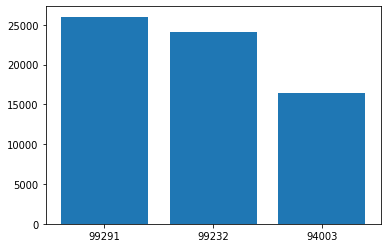

In [4]:
import matplotlib.pyplot as plt

x = note_cpt_4['CPT_CD'].astype(str).value_counts()

plt.bar(x.index, x)

# Clean the Text

In [167]:
import re

# Remove \n
# Find all capitalized words followed by a colon
# lowercase all words
# Remove all numbers
# Remove all punctuation

sample = note_cpt_4.iloc[1,:]['TEXT']

# # re.sub('(\[\*\*.*\*\*\])', '', sample) # Remove anything in brackets [**x**]
z = re.findall('([A-Z\s]+:)',sample) # Find all capitalized words followed by a colon
[x.strip().replace(':','') for x in z]
# # sample

# for i,x in enumerate(re.split('([A-Z\s]+:)',sample)):
#     print(i, x, '\n\n\n\n')

# # # sample
# note_cpt_4.iloc[0,:]

# Find which categories to keep
# CHIEF COMPLAINT, HISTORY OF PRESENT ILLNESS, PHYSICAL EXAMINATION ON PRESENTATION, IMAGING, anything ending in ISSUES

# updated_list = list(re.split('([A-Z\s]+:)',sample))
# for i in updated_list:
#     print(i)
# boolean_ls = []

# for i, x in enumerate(updated_list):
#     if 'CHIEF COMPLAINT' in x:
#         boolean_ls.append(updated_list[i+1])
#     elif 'ISSUES:' in x:
#         boolean_ls.append(updated_list[i+1])
        
# def clean_text(data):
#     """Remove note sections not applicable to CPT"""
    
#     data = data.reset_index()
#     for df_index, df_value in enumerate(data['TEXT']):
#         temp_ls = []
#         row_text = list(re.split('([A-Z\s]+:)',df_value))
#         for index, value in enumerate(row_text):
#             if 'CHIEF COMPLAINT:' in value:
#                 temp_ls.append(row_text[index+1])
#             elif 'ISSUES:' in value:
#                 temp_ls.append(row_text[index+1])
#             elif 'HISTORY OF PRESENT ILLNESS:' in value:
#                 temp_ls.append(row_text[index+1])
#             elif 'IMAGING:' in value:
#                 temp_ls.append(row_text[index+1])
#         data.loc[df_index, 'TEXT'] = ' '.join(temp_ls)
    
#     return data
        
# x = clean_text(note_cpt_4.head())

# note_cpt_4.head().reset_index().loc[4, 'TEXT']
# re.findall('[a-z]', x)
# re.findall('1', 'hi my name is 1')

# Find all topics and then filter to applicable topics

def find_topics(data):
    master_list = []
    for index, row_data in data.iterrows():
        topics = re.findall('([A-Z\s]+:)',row_data['TEXT']) # Find all capitalized words followed by a colon
        topics = [x.strip().replace(':','').replace('\n', '') for x in topics]
        master_list += topics
    master_dict = {}
    for i in master_list:
        if i not in master_dict:
            master_dict[i] = [master_list.count(i)]
    print(master_dict)
    return df.melt().sort_values(by='value', ascending=False)

df = find_topics(note_cpt_4)


{'CHIEF COMPLAINT': [1284], 'HISTORY OF PRESENT ILLNESS': [5440], 'PAST MEDICAL HISTORY': [8565], 'ALLERGIES': [7002], 'MEDICATIONS ON ADMISSION': [3024], 'SOCIAL HISTORY': [5926], 'PHYSICAL EXAMINATION ON PRESENTATION': [979], 'PERTINENT LABORATORY DATA ON PRESENTATION': [149], 'IMAGING': [3849], 'HOSPITAL COURSE BY SYSTEM': [117], 'CARDIOVASCULAR': [779], 'SEPSIS': [122], 'PULMONARY': [547], 'RENAL': [441], 'NUTRITION': [266], 'VASCULAR': [54], 'HEMATOLOGY': [311], 'CONDITION AT DISCHARGE': [1195], 'DISCHARGE STATUS': [3320], 'DISCHARGE DIAGNOSES': [4408], 'MEDICATIONS ON DISCHARGE': [1892], 'CODE STATUS': [764], 'NOTE': [575], 'D': [11921], 'T': [23564], 'FAMILY HISTORY': [3173], 'PERTINENT LABORATORY VALUES ON PRESENTATION': [702], 'SYSTEM': [482], 'PULMONARY ISSUES': [134], 'BACTEREMIA ISSUES': [9], 'CIRRHOSIS ISSUES': [10], 'HUMAN IMMUNODEFICIENCY VIRUS ISSUES': [6], 'DIABETES MELLITUS ISSUES': [46], 'HYPOTHYROIDISM ISSUES': [24], 'ACCESS ISSUES': [43], 'FOLLOWUP': [959], 'ADMISS

# Find the Topics to Subset to

In [183]:
pd.options.display.max_rows = 500
df.head(499)

# SOCIAL HISTORY, MEDICATION, FAMILY HISTORY

,variable,value
114,IMPRESSION,67726
45,HEENT,43347
80,CV,24961
24,T,23564
78,VS,15616
113,FINDINGS,15429
103,BP,14882
221,CXR,13582
168,H,12752
23,D,11921


# Filter the data

In [5]:
import string

def clean_data(text_series):
    
    # Replace \n 
    text_series = text_series.str.replace('\\n',' ', regex=True)    

    # Remove dates and locations
    text_series = text_series.str.replace('\[\*\*(.*?)\*\*\]', ' ', regex=True)
    
    # Remove topics
    data = text_series.str.split('([A-Z\s]+:)')
    for row_num, value in enumerate(data):
        text_chunks = [x.strip().replace(':','').replace('\n', '') for x in value]
        for i, x in enumerate(text_chunks):
            if 'MEDICATION' in x or 'SOCIAL HISTORY' in x or 'FAMILY HISTORY' in x:
                text_chunks[i] = ' '
                try:
                    text_chunks[i + 1] = ' '
                except:
                    continue

        text_series.iloc[row_num] = ' '.join(text_chunks)
    
    # Replace punctuation
    text_series = text_series.str.replace('[' + string.punctuation + ']', ' ', regex=True)
    
    # Convert to lowercase 
    text_series = text_series.str.lower()
    
    # Remove all digits
    text_series = text_series.str.replace('\d',' ', regex=True)
    
    return text_series

note_cpt_4_clean = clean_data(note_cpt_4['TEXT'])
note_cpt_4_clean

1         admission date        discharge date     date ...
4         admission date        discharge date     date ...
10        admission date          discharge date     dat...
11        admission date          discharge date     dat...
13        admission date          discharge date    date...
                                ...                        
223123    admission date                 discharge date ...
223124    admission date                 discharge date ...
223130    admission date                 discharge date ...
223134    admission date                 discharge date ...
223135    admission date                 discharge date ...
Name: TEXT, Length: 66480, dtype: object

In [352]:
# note_cpt_4.loc[:, 'TEXT'] = note_cpt_4_clean.values
note_cpt_4

,SUBJECT_ID,HADM_ID,TEXT,CPT_CD
1,3,145834.0,admission date discharge date date of...,94003
4,4,185777.0,admission date discharge date date of...,99232
10,6,107064.0,admission date discharge date date ...,99232
11,6,107064.0,admission date discharge date date ...,99291
13,9,150750.0,admission date discharge date date o...,94003
...,...,...,...,...
223123,99985,176670.0,admission date discharge date ...,94003
223124,99991,151118.0,admission date discharge date ...,99291
223130,99992,197084.0,admission date discharge date ...,99291
223134,99995,137810.0,admission date discharge date ...,99291


# Split the Data

In [6]:
# Import Packages -----

from nltk.corpus import stopwords

my_stop_words = list(set(stopwords.words('english'))) + ['admission', 'date', 'sex']


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Split the data -----

X_train, X_test, y_train, y_test = train_test_split(note_cpt_4['TEXT'], note_cpt_4['CPT_CD'].astype(str), test_size = .33, random_state = 42)


# Tokenize the data

In [7]:
# Tokenize the data -----

# Import TfidfVectorizer
count_vectorizer = CountVectorizer(stop_words=my_stop_words)

# Transform the training data
count_train = count_vectorizer.fit_transform(X_train)

# Transform the test data
count_test = count_vectorizer.transform(X_test)

# print(tfidf_vectorizer.get_feature_names()[:10])

# Run Naive Bayes

In [8]:
# Use Naive Bayes model -----

from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

nb_classifier = MultinomialNB()

# Fit and check accuracy
nb_classifier.fit(count_train, y_train)
pred = nb_classifier.predict(count_test)

# Looking at Feature Names and Weights

In [9]:
class_labels = nb_classifier.classes_
# len(class_labels) # 24

# len(nb_classifier.coef_) # 24
# (nb_classifier.coef_[0] ==  nb_classifier.coef_[1]) # They are unique to each CPT code, but are for the same features

# len(feature_names) # 207,838

# Zip together the first CPT weights with feature names
# feat_with_weights =  sorted(zip(nb_classifier.coef_[0], feature_names))

# # Class label with weights
# print(class_labels[0])

# for i in range(100):
#     print(i, feat_with_weights[-i])

# # Print dataframe # ran into memory error
# # (tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())
# # tfidf_df.head()
# import numpy as np

# np.exp(1)**-8.5
# # Taken from here: * https://stackoverflow.com/questions/61586946/how-to-calculate-feature-log-prob-in-the-naive-bayes-multinomialnb

# Classification Report

In [10]:
# Create classification report taken from here: https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568
from sklearn.metrics import classification_report

print(classification_report(y_test, pred,target_names=class_labels))


              precision    recall  f1-score   support

       94003       0.41      0.58      0.48      5456
       99232       0.37      0.24      0.29      7937
       99291       0.41      0.43      0.42      8546

    accuracy                           0.40     21939
   macro avg       0.39      0.42      0.39     21939
weighted avg       0.39      0.40      0.39     21939



In [11]:
metrics.accuracy_score(y_test, pred)

# """
# V1 NLP Model Accuracy: 0.117
# Wow, I've got a long way to go to improve accuracy
# V2 NLP Model Accuracy: 0.14
# V3 NLP Model Accuracy: .40
# """

# Confusion matrix 
# confusion_mtrx = metrics.confusion_matrix(y_test.astype(str), pred) # 1380, 1380
# confusion_mtrx

0.39728337663521585

In [3]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

def my_tokenizer(text):
    lemmatizer = WordNetLemmatizer()

    tokens = word_tokenize(text)
    tokens_tag = nltk.pos_tag(tokens)
    tokens_tag = [(i[0], get_wordnet_pos(i[1])) for i in tokens_tag]
    
    # Remove ly
    final_tokens = [lemmatizer.lemmatize(i[0], i[1]) if i[1] != '' else i[0] for i in tokens_tag]
    return final_tokens

# Run stop words through my tokenizer
my_tokenizer('She ran and running and runs quickly and quietly')

['She', 'run', 'and', 'run', 'and', 'run', 'quickly', 'and', 'quietly']